# 仅使用XGBoost进行结果预测

Gold                                        int64
Total                                       int64
NOC                                         int64
Year                                        int64
isHost                                      int64
                                           ...   
NM_Cycling Road, Cycling Mountain Bike      int64
NM_Cycling Road, Triathlon                  int64
NM_3x3 Basketball, Basketball               int64
Country                                    object
Year_Standardized                         float64
Length: 159, dtype: object
Gold Prediction:
Train - Mean Absolute Error: 0.2014
Train - Mean Squared Error: 0.0721
Train RMSE: 0.2686
Train - R^2 Score: 0.9986
Test - Mean Absolute Error: 1.4955
Test - Mean Squared Error: 10.6815
Test RMSE: 3.2683
Test - R^2 Score: 0.8342


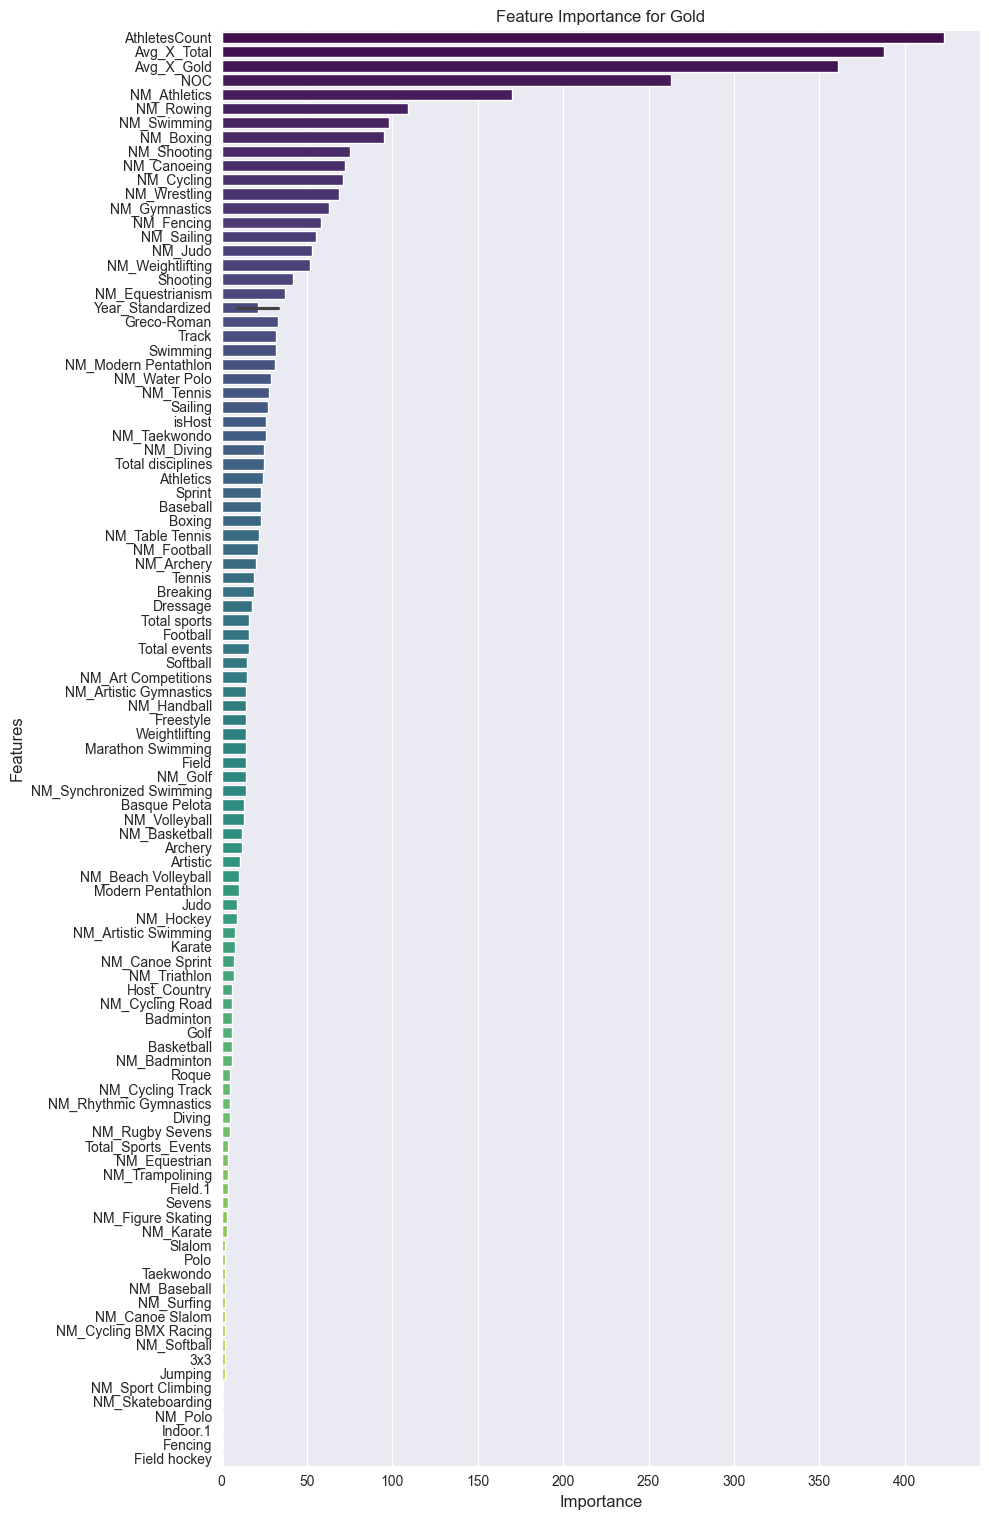

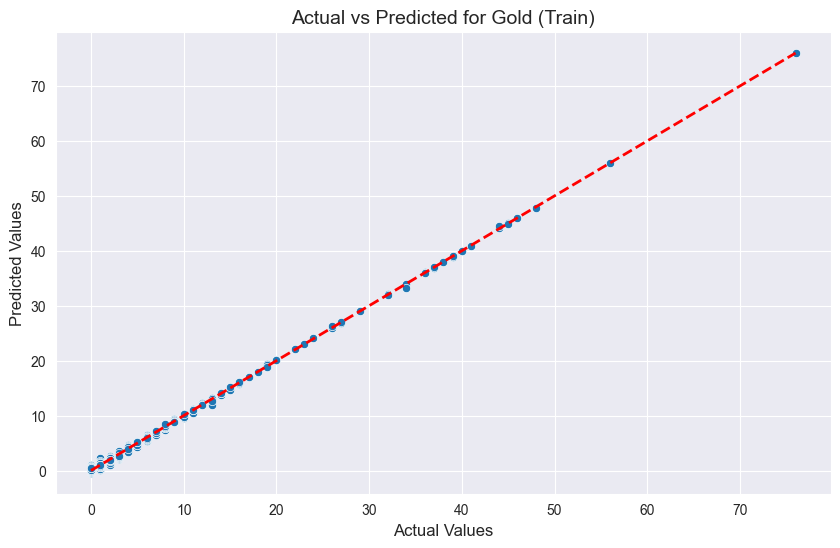

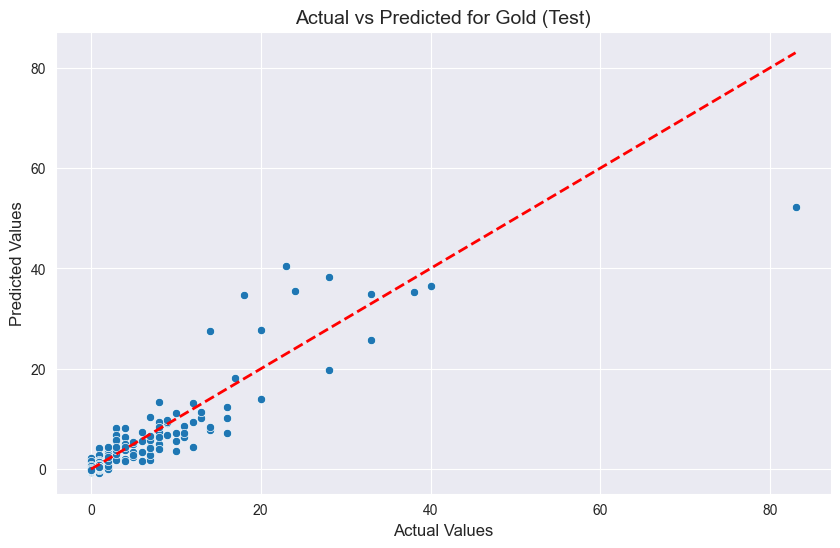

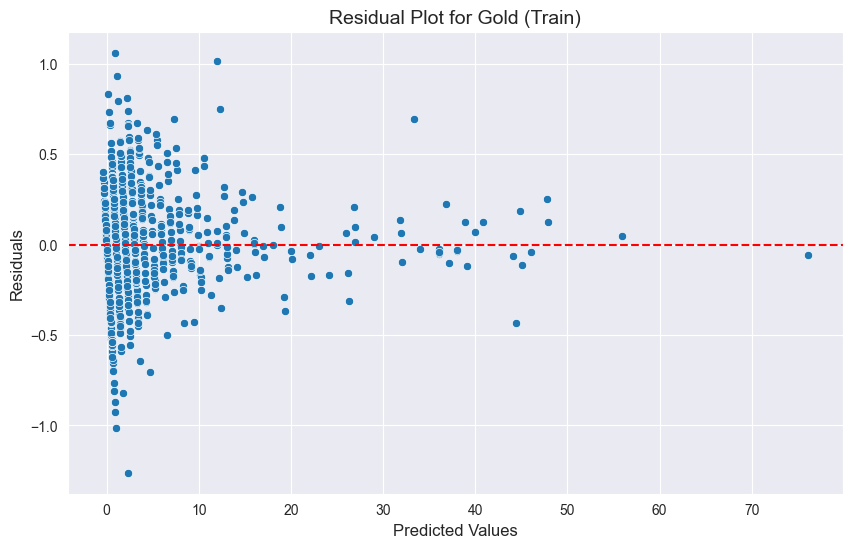

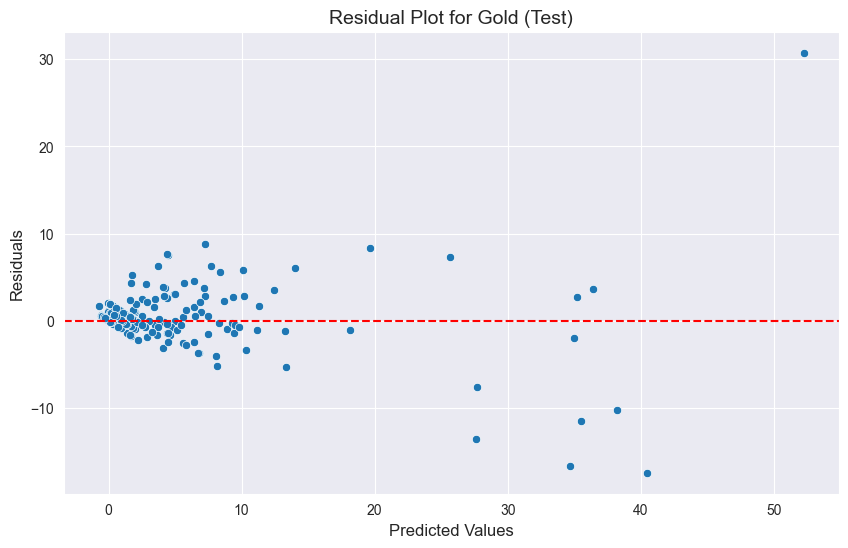

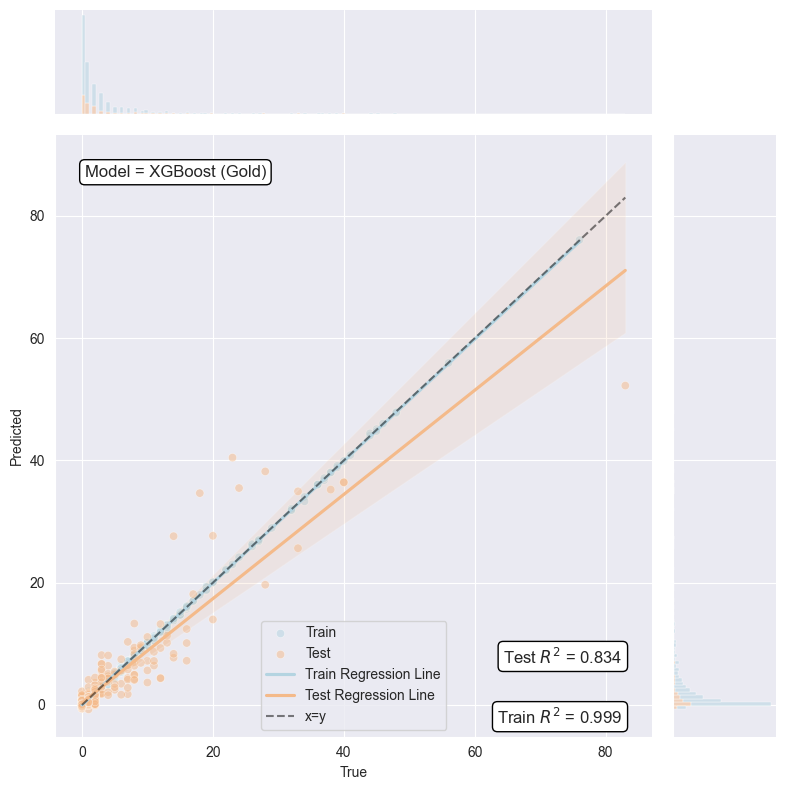

Total Prediction:
Train - Mean Absolute Error: 0.2176
Train - Mean Squared Error: 0.0846
Train RMSE: 0.2909
Train - R^2 Score: 0.9998
Test - Mean Absolute Error: 2.1812
Test - Mean Squared Error: 25.5390
Test RMSE: 5.0536
Test - R^2 Score: 0.9321


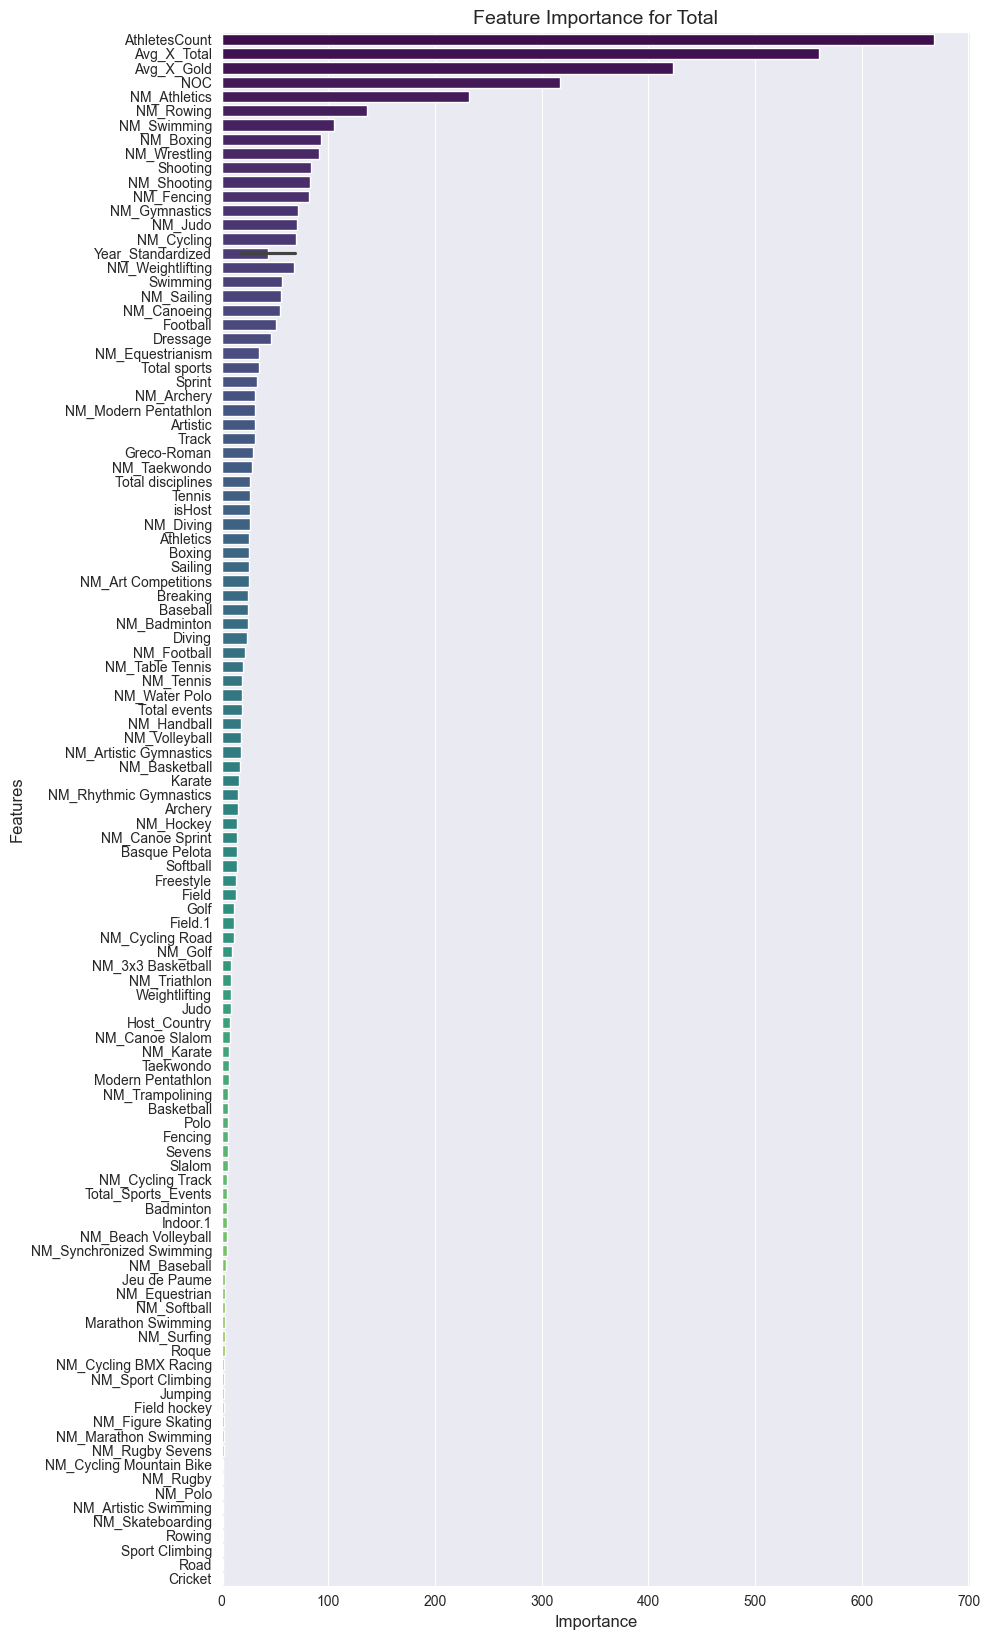

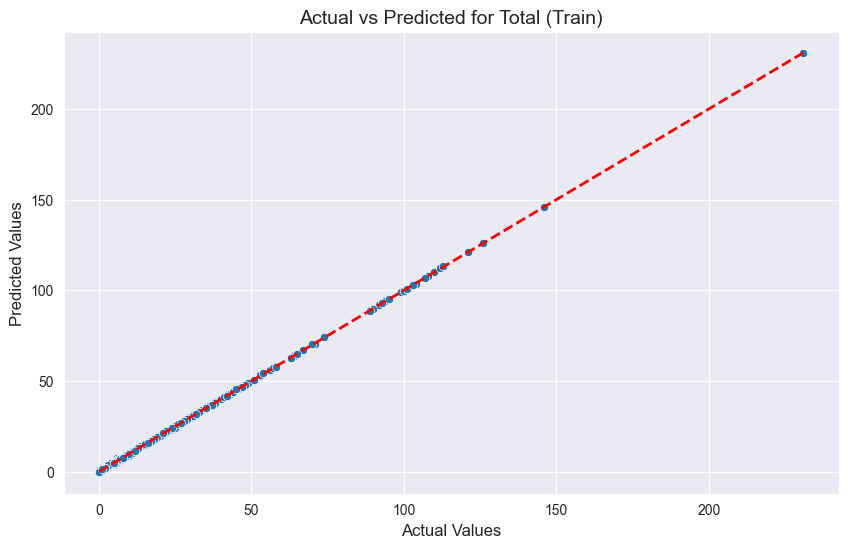

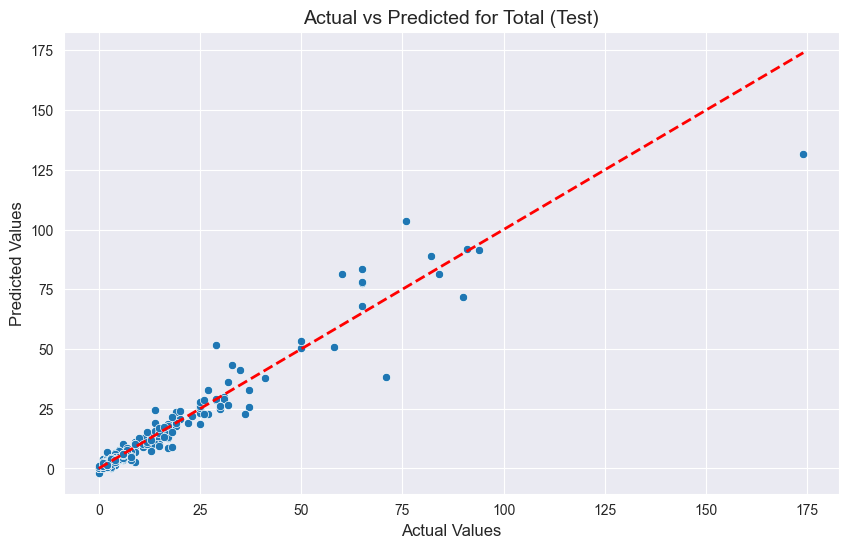

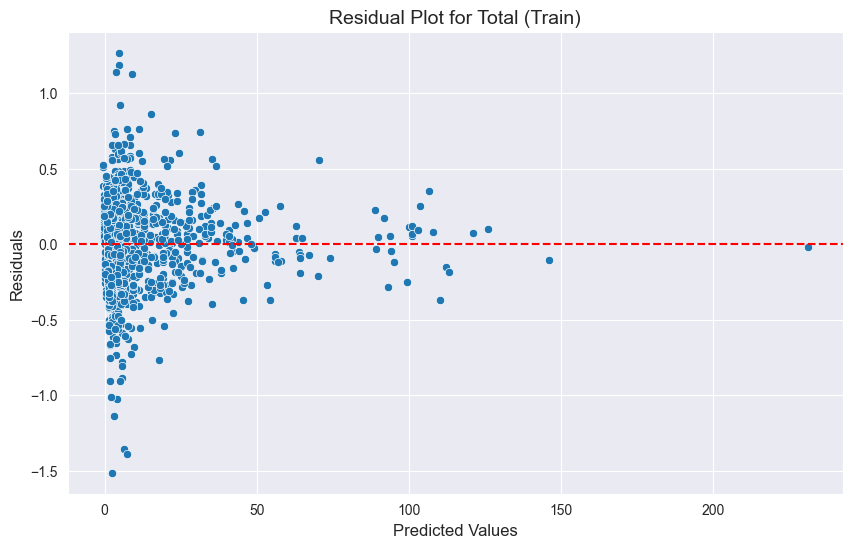

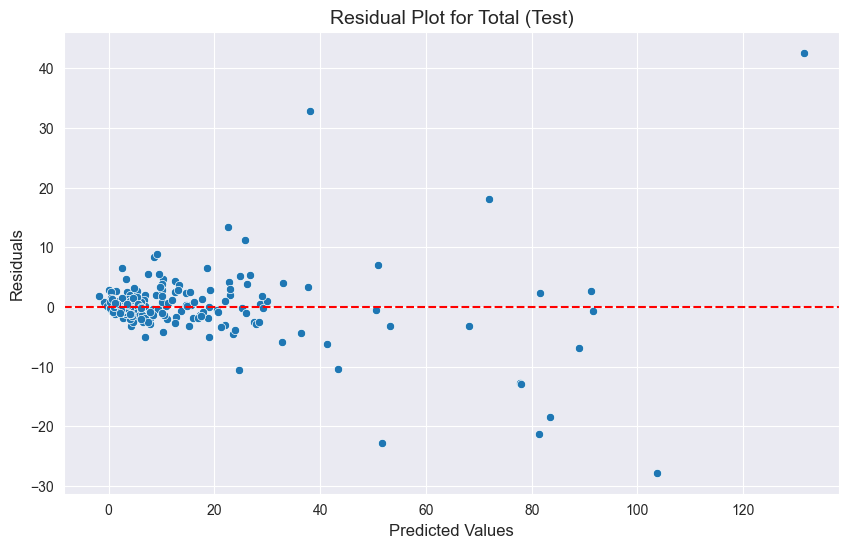

Text(0.05, 0.95, 'Model = XGBoost (Total)')

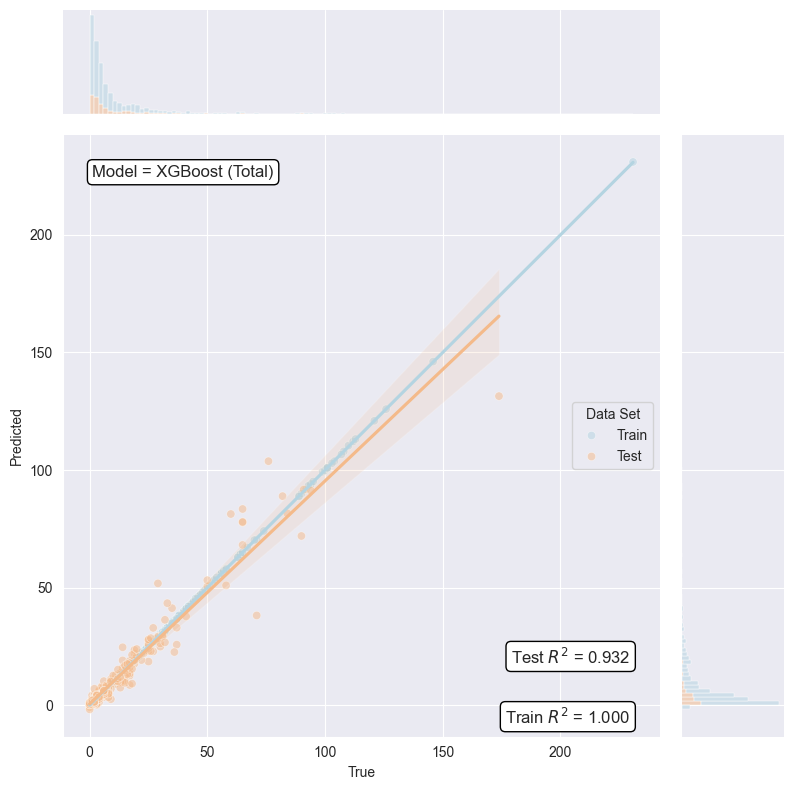

In [97]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split

# 读取数据
file_path = "./data/merged_final_data.csv"
df = pd.read_csv(file_path)

# 序列化 NOC 列
le = LabelEncoder()
df['Country'] = df['NOC'].copy() 
df['NOC'] = le.fit_transform(df['NOC'].astype(str))
df['NOC'] = df['NOC'].astype(int)
joblib.dump(le, 'label_encoder.pkl')

# 标准化 Year 列


scaler = StandardScaler()
df['Year_Standardized'] = scaler.fit_transform(df[['Year']])

print(df.dtypes)

# 选择特征和目标变量
features = df.columns[4:].tolist()  # 从第五列到最后一列作为特征
features.append('NOC')  # 添加序列化后的 NOC 列
features.append('Year_Standardized')  # 添加标准化后的 Year 列
features = [col for col in features if col != 'Country']

target_gold = 'Gold'
target_total = 'Total'

# 分离特征和目标变量
X = df[features]
y_gold = df[target_gold]
y_total = df[target_total]

# 切分训练集和测试集
X_train, X_test, y_train_gold, y_test_gold = train_test_split(X, y_gold, test_size=0.2, random_state=7)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=7)

# 确保 X_train 和 X_test 是 DataFrame 类型
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

# 最优参数
best_params = {
    'n_estimators': 850,
    'max_depth': 3,
    'learning_rate': 0.22504880706544744,
    'subsample': 0.5534027539665659,
    'colsample_bytree': 0.7885661336486579,
    'reg_lambda': 1.0442478073580164,  # L2 正则化项
    'gamma': 0.28845608683232876,      # 最小损失减少阈值
    'random_state': 42
}

# 使用最优参数训练 Gold 模型
bst_gold = xgb.XGBRegressor(**best_params)
bst_gold.fit(X_train.values, y_train_gold.values)  # 使用 .values 转换为 NumPy 数组
ypred_train_gold = bst_gold.predict(X_train.values)
ypred_test_gold = bst_gold.predict(X_test.values)

# 输出 Gold 模型的评价指标
print('Gold Prediction:')
mae_train_gold = metrics.mean_absolute_error(y_train_gold, ypred_train_gold)
mse_train_gold = metrics.mean_squared_error(y_train_gold, ypred_train_gold)
r2_train_gold = metrics.r2_score(y_train_gold, ypred_train_gold)

mae_test_gold = metrics.mean_absolute_error(y_test_gold, ypred_test_gold)
mse_test_gold = metrics.mean_squared_error(y_test_gold, ypred_test_gold)
r2_test_gold = metrics.r2_score(y_test_gold, ypred_test_gold)

rmse_train_gold = np.sqrt(mse_train_gold)
rmse_test_gold = np.sqrt(mse_test_gold)

print(f'Train - Mean Absolute Error: {mae_train_gold:.4f}')
print(f'Train - Mean Squared Error: {mse_train_gold:.4f}')
print(f"Train RMSE: {rmse_train_gold:.4f}")
print(f'Train - R^2 Score: {r2_train_gold:.4f}')

print(f'Test - Mean Absolute Error: {mae_test_gold:.4f}')
print(f'Test - Mean Squared Error: {mse_test_gold:.4f}')
print(f"Test RMSE: {rmse_test_gold:.4f}")
print(f'Test - R^2 Score: {r2_test_gold:.4f}')

# 保存 Gold 模型
joblib.dump(bst_gold, 'xgb_model_gold.pkl')

# 绘制 Gold 模型的特征重要性图
feature_importance_gold = bst_gold.get_booster().get_score(importance_type='weight')
features_gold = [X_train.columns[int(f[1:])] for f in feature_importance_gold.keys()]  # 映射列名
importance_gold = list(feature_importance_gold.values())

# 按重要性分数降序排序
sorted_indices = np.argsort(importance_gold)[::-1]
features_gold = [features_gold[i] for i in sorted_indices]
importance_gold = [importance_gold[i] for i in sorted_indices]

plt.figure(figsize=(10, len(features_gold) * 0.15))  # 根据特征数量动态调整高度
sns.barplot(x=importance_gold, y=features_gold, orient='h', hue=features_gold, palette='viridis', legend=False)
plt.title('Feature Importance for Gold', fontsize=12)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# 绘制 Gold 模型的实际值与预测值的散点图（训练集）
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_gold, y=ypred_train_gold)
plt.title('Actual vs Predicted for Gold (Train)', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.plot([y_train_gold.min(), y_train_gold.max()], [y_train_gold.min(), y_train_gold.max()], 'r--', lw=2)
plt.show()

# 绘制 Gold 模型的实际值与预测值的散点图（测试集）
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_gold, y=ypred_test_gold)
plt.title('Actual vs Predicted for Gold (Test)', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.plot([y_test_gold.min(), y_test_gold.max()], [y_test_gold.min(), y_test_gold.max()], 'r--', lw=2)
plt.show()

# 绘制 Gold 模型的残差图（训练集）
residuals_train_gold = y_train_gold - ypred_train_gold
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ypred_train_gold, y=residuals_train_gold)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Gold (Train)', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.show()

# 绘制 Gold 模型的残差图（测试集）
residuals_test_gold = y_test_gold - ypred_test_gold
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ypred_test_gold, y=residuals_test_gold)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Gold (Test)', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.show()

# ===== 新增：Gold 模型的联合散点图与回归线 =====
# 准备数据
data_train_gold = pd.DataFrame({
    'True': y_train_gold,  # 训练集真实值
    'Predicted': ypred_train_gold  # 训练集预测值
})
data_train_gold['Data Set'] = 'Train'  # 添加数据集标签

data_test_gold = pd.DataFrame({
    'True': y_test_gold,  # 测试集真实值
    'Predicted': ypred_test_gold  # 测试集预测值
})
data_test_gold['Data Set'] = 'Test'  # 添加数据集标签

# 合并训练集和测试集
data_gold = pd.concat([data_train_gold, data_test_gold])

# 自定义调色板
palette = {'Train': '#b4d4e1', 'Test': '#f4ba8a'}

# 创建 JointGrid 对象
g = sns.JointGrid(data=data_gold, x="True", y="Predicted", hue="Data Set", height=8, palette=palette)

# 绘制中心的散点图
g.plot_joint(sns.scatterplot, alpha=0.5)

# 添加训练集的回归线
sns.regplot(data=data_train_gold, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#b4d4e1', label='Train Regression Line')

# 添加测试集的回归线
sns.regplot(data=data_test_gold, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#f4ba8a', label='Test Regression Line')

# 添加边缘的柱状图
g.plot_marginals(sns.histplot, kde=False, element='bars', multiple='stack', alpha=0.5)

# 计算 R^2 分数
r2_train_gold = metrics.r2_score(data_train_gold['True'], data_train_gold['Predicted'])
r2_test_gold = metrics.r2_score(data_test_gold['True'], data_test_gold['Predicted'])

# 添加拟合优度文本在右上角
ax = g.ax_joint
ax.text(0.95, 0.05, f'Train $R^2$ = {r2_train_gold:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

ax.text(0.95, 0.15, f'Test $R^2$ = {r2_test_gold:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# 在左上角添加模型名称文本
ax.text(0.05, 0.95, 'Model = XGBoost (Gold)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# 添加中心线 (x=y)
ax.plot([data_gold['True'].min(), data_gold['True'].max()], [data_gold['True'].min(), data_gold['True'].max()], c="black", alpha=0.5, linestyle='--', label='x=y')
ax.legend()

plt.show()
# ===== 新增结束 =====

# 使用最优参数训练 Total 模型
bst_total = xgb.XGBRegressor(**best_params)
bst_total.fit(X_train.values, y_train_total.values)  # 使用 .values 转换为 NumPy 数组
ypred_train_total = bst_total.predict(X_train.values)
ypred_test_total = bst_total.predict(X_test.values)

# 输出 Total 模型的评价指标
print('Total Prediction:')
mae_train_total = metrics.mean_absolute_error(y_train_total, ypred_train_total)
mse_train_total = metrics.mean_squared_error(y_train_total, ypred_train_total)
r2_train_total = metrics.r2_score(y_train_total, ypred_train_total)

mae_test_total = metrics.mean_absolute_error(y_test_total, ypred_test_total)
mse_test_total = metrics.mean_squared_error(y_test_total, ypred_test_total)
r2_test_total = metrics.r2_score(y_test_total, ypred_test_total)

rmse_train_total = np.sqrt(mse_train_total)
rmse_test_total = np.sqrt(mse_test_total)

print(f'Train - Mean Absolute Error: {mae_train_total:.4f}')
print(f'Train - Mean Squared Error: {mse_train_total:.4f}')
print(f"Train RMSE: {rmse_train_total:.4f}")
print(f'Train - R^2 Score: {r2_train_total:.4f}')

print(f'Test - Mean Absolute Error: {mae_test_total:.4f}')
print(f'Test - Mean Squared Error: {mse_test_total:.4f}')
print(f"Test RMSE: {rmse_test_total:.4f}")
print(f'Test - R^2 Score: {r2_test_total:.4f}')

# 保存 Total 模型
joblib.dump(bst_total, 'xgb_model_total.pkl')

# 绘制 Total 模型的特征重要性图
feature_importance_total = bst_total.get_booster().get_score(importance_type='weight')
features_total = [X_train.columns[int(f[1:])] for f in feature_importance_total.keys()]  # 映射列名
importance_total = list(feature_importance_total.values())

# 按重要性分数降序排序
sorted_indices = np.argsort(importance_total)[::-1]
features_total = [features_total[i] for i in sorted_indices]
importance_total = [importance_total[i] for i in sorted_indices]

plt.figure(figsize=(10, len(features_total) * 0.15))  # 根据特征数量动态调整高度
sns.barplot(x=importance_total, y=features_total, orient='h', hue=features_total, palette='viridis', legend=False)
plt.title('Feature Importance for Total', fontsize=14)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.tight_layout()
plt.show()

# 绘制 Total 模型的实际值与预测值的散点图（训练集）
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_train_total, y=ypred_train_total)
plt.title('Actual vs Predicted for Total (Train)', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.plot([y_train_total.min(), y_train_total.max()], [y_train_total.min(), y_train_total.max()], 'r--', lw=2)
plt.show()

# 绘制 Total 模型的实际值与预测值的散点图（测试集）
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test_total, y=ypred_test_total)
plt.title('Actual vs Predicted for Total (Test)', fontsize=14)
plt.xlabel('Actual Values', fontsize=12)
plt.ylabel('Predicted Values', fontsize=12)
plt.plot([y_test_total.min(), y_test_total.max()], [y_test_total.min(), y_test_total.max()], 'r--', lw=2)
plt.show()

# 绘制 Total 模型的残差图（训练集）
residuals_train_total = y_train_total - ypred_train_total
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ypred_train_total, y=residuals_train_total)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Total (Train)', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.show()

# 绘制 Total 模型的残差图（测试集）
residuals_test_total = y_test_total - ypred_test_total
plt.figure(figsize=(10, 6))
sns.scatterplot(x=ypred_test_total, y=residuals_test_total)
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Residual Plot for Total (Test)', fontsize=14)
plt.xlabel('Predicted Values', fontsize=12)
plt.ylabel('Residuals', fontsize=12)
plt.show()

# ===== 新增：Total 模型的联合散点图与回归线 =====
# 准备数据
data_train_total = pd.DataFrame({
    'True': y_train_total,  # 训练集真实值
    'Predicted': ypred_train_total  # 训练集预测值
})
data_train_total['Data Set'] = 'Train'  # 添加数据集标签

data_test_total = pd.DataFrame({
    'True': y_test_total,  # 测试集真实值
    'Predicted': ypred_test_total  # 测试集预测值
})
data_test_total['Data Set'] = 'Test'  # 添加数据集标签

# 合并训练集和测试集
data_total = pd.concat([data_train_total, data_test_total])

# 自定义调色板
palette = {'Train': '#b4d4e1', 'Test': '#f4ba8a'}

# 创建 JointGrid 对象
g = sns.JointGrid(data=data_total, x="True", y="Predicted", hue="Data Set", height=8, palette=palette)

# 绘制中心的散点图
g.plot_joint(sns.scatterplot, alpha=0.5)

# 添加训练集的回归线
sns.regplot(data=data_train_total, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#b4d4e1', label='Train Regression Line')

# 添加测试集的回归线
sns.regplot(data=data_test_total, x="True", y="Predicted", scatter=False, ax=g.ax_joint, color='#f4ba8a', label='Test Regression Line')

# 添加边缘的柱状图
g.plot_marginals(sns.histplot, kde=False, element='bars', multiple='stack', alpha=0.5)

# 计算 R^2 分数
r2_train_total = metrics.r2_score(data_train_total['True'], data_train_total['Predicted'])
r2_test_total = metrics.r2_score(data_test_total['True'], data_test_total['Predicted'])

# 添加拟合优度文本在右上角
ax = g.ax_joint
ax.text(0.95, 0.05, f'Train $R^2$ = {r2_train_total:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

ax.text(0.95, 0.15, f'Test $R^2$ = {r2_test_total:.3f}', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# 在左上角添加模型名称文本
ax.text(0.05, 0.95, 'Model = XGBoost (Total)', transform=ax.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

# 添加中心线 (x=y)

In [90]:
# 假设 df 是包含所有国家数据的 DataFrame
# 筛选出 Year == 2024 的数据
data_2024 = df[df['Year'] == 2024].copy()

# 将 Year 替换为 2028
data_2024['Year'] = 2028

# 确保特征列与训练时一致
X_2024 = data_2024[X_train.columns]  # 使用训练时的特征列

# 检查特征列是否一致
print("训练特征列：", X_train.columns)
print("预测特征列：", X_2024.columns)

# 使用 Gold 模型进行预测
gold_predictions_2028 = bst_gold.predict(X_2024.values)

# 使用 Total 模型进行预测
total_predictions_2028 = bst_total.predict(X_2024.values)

# 将预测结果添加到数据中
data_2024['Predicted_Gold'] = gold_predictions_2028
data_2024['Predicted_Total'] = total_predictions_2028

# 检查预测结果中是否存在 NaN
print("预测结果中 NaN 的数量：")
print(data_2024[['Predicted_Gold', 'Predicted_Total']].isna().sum())

# 仅保留需要的列
result_2028 = data_2024[['Country', 'Predicted_Gold', 'Predicted_Total']]

# 保存预测结果到 CSV 文件
result_2028.to_csv('predictions_2028.csv', index=False)

# 输出预测结果
print("2028 年奥运会得奖情况预测结果：")
print(result_2028.head(10))

训练特征列： Index(['isHost', 'Avg_X_Gold', 'Avg_X_Total', 'AthletesCount', 'Diving',
       'Marathon Swimming', 'Swimming', 'Water Polo', 'Archery', 'Athletics',
       ...
       'NM_Sport Climbing', 'NM_Marathon Swimming, Swimming', 'NM_Breaking',
       'NM_Cycling Road, Cycling Track',
       'NM_Cycling Road, Cycling Mountain Bike', 'NM_Cycling Road, Triathlon',
       'NM_3x3 Basketball, Basketball', 'Year_Standardized', 'NOC',
       'Year_Standardized'],
      dtype='object', length=156)
预测特征列： Index(['isHost', 'Avg_X_Gold', 'Avg_X_Total', 'AthletesCount', 'Diving',
       'Marathon Swimming', 'Swimming', 'Water Polo', 'Archery', 'Athletics',
       ...
       'NM_Sport Climbing', 'NM_Marathon Swimming, Swimming', 'NM_Breaking',
       'NM_Cycling Road, Cycling Track',
       'NM_Cycling Road, Cycling Mountain Bike', 'NM_Cycling Road, Triathlon',
       'NM_3x3 Basketball, Basketball', 'Year_Standardized', 'NOC',
       'Year_Standardized'],
      dtype='object', length=156)
预测结果中 

# 采用Bootstrap+XGBoost进行训练与预测以得到预测区间

In [1]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from tqdm import tqdm  # 用于显示进度条

# 读取数据
file_path = "./data/merged_final_data.csv"
df = pd.read_csv(file_path)

# 序列化 NOC 列
le = LabelEncoder()
df['Country'] = df['NOC'].copy() 
df['NOC'] = le.fit_transform(df['NOC'].astype(str))
df['NOC'] = df['NOC'].astype(int)
joblib.dump(le, 'label_encoder.pkl')

# 标准化 Year 列
scaler = StandardScaler()
df['Year_Standardized'] = scaler.fit_transform(df[['Year']])

print(df.dtypes)

# 选择特征和目标变量
features = df.columns[4:].tolist()  # 从第五列到最后一列作为特征
features.append('NOC')  # 添加序列化后的 NOC 列
features.append('Year_Standardized')  # 添加标准化后的 Year 列
features = [col for col in features if col != 'Country']

target_gold = 'Gold'
target_total = 'Total'

# 分离特征和目标变量
X = df[features]
y_gold = df[target_gold]
y_total = df[target_total]

# 切分训练集和测试集
X_train, X_test, y_train_gold, y_test_gold = train_test_split(X, y_gold, test_size=0.2, random_state=7)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=7)

# 确保 X_train 和 X_test 是 DataFrame 类型
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)

"""# 定义目标函数（用于超参数优化）
def objective(params):
    model = xgb.XGBRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        learning_rate=params['learning_rate'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        reg_lambda=params['lambda'],  # L2 正则化项
        gamma=params['gamma'],        # 最小损失减少阈值
        random_state=42
    )
    # 将 X_train 和 y_train_gold 转换为 numpy.ndarray
    model.fit(X_train.values, y_train_gold.values)
    y_pred = model.predict(X_test.values)
    rmse = np.sqrt(metrics.mean_squared_error(y_test_gold, y_pred))
    return {'loss': rmse, 'status': STATUS_OK}

# 定义超参数空间
space = {
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 50),
    'max_depth': hp.quniform('max_depth', 3, 12, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
    'lambda': hp.uniform('lambda', 0.1, 2.0),  # L2 正则化项
    'gamma': hp.uniform('gamma', 0, 0.5)      # 最小损失减少阈值
}

# 使用 TPE 优化超参数
trials = Trials()
best = fmin(fn=objective, space=space, algo=tpe.suggest, max_evals=50, trials=trials)

# 最优参数
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'learning_rate': best['learning_rate'],
    'subsample': best['subsample'],
    'colsample_bytree': best['colsample_bytree'],
    'lambda': best['lambda'],  # L2 正则化项
    'gamma': best['gamma']     # 最小损失减少阈值
}

# 打印最优参数
print(f"Best Parameters: {best_params}")"""

# 最优参数
best_params = {
    'n_estimators': 850,
    'max_depth': 3,
    'learning_rate': 0.22504880706544744,
    'subsample': 0.5534027539665659,
    'colsample_bytree': 0.7885661336486579,
    'reg_lambda': 1.0442478073580164,  # L2 正则化项
    'gamma': 0.28845608683232876,      # 最小损失减少阈值
    'random_state': 42
}

# 使用最优参数训练 Gold 模型
# bst_gold = xgb.XGBRegressor(**best_params)
# 使用默认参数训练 Gold 模型
bst_gold = xgb.XGBRegressor(**best_params)
bst_gold.fit(X_train.values, y_train_gold.values)  # 使用 .values 转换为 NumPy 数组
ypred_train_gold = bst_gold.predict(X_train.values)
ypred_test_gold = bst_gold.predict(X_test.values)

# 输出 Gold 模型的评价指标
print('Gold Prediction:')
mae_train_gold = metrics.mean_absolute_error(y_train_gold, ypred_train_gold)
mse_train_gold = metrics.mean_squared_error(y_train_gold, ypred_train_gold)
r2_train_gold = metrics.r2_score(y_train_gold, ypred_train_gold)

mae_test_gold = metrics.mean_absolute_error(y_test_gold, ypred_test_gold)
mse_test_gold = metrics.mean_squared_error(y_test_gold, ypred_test_gold)
r2_test_gold = metrics.r2_score(y_test_gold, ypred_test_gold)

rmse_train_gold = np.sqrt(mse_train_gold)
rmse_test_gold = np.sqrt(mse_test_gold)

print(f'Train - Mean Absolute Error: {mae_train_gold:.4f}')
print(f'Train - Mean Squared Error: {mse_train_gold:.4f}')
print(f"Train RMSE: {rmse_train_gold:.4f}")
print(f'Train - R^2 Score: {r2_train_gold:.4f}')

print(f'Test - Mean Absolute Error: {mae_test_gold:.4f}')
print(f'Test - Mean Squared Error: {mse_test_gold:.4f}')
print(f"Test RMSE: {rmse_test_gold:.4f}")
print(f'Test - R^2 Score: {r2_test_gold:.4f}')

# 保存 Gold 模型
joblib.dump(bst_gold, 'xgb_model_gold.pkl')

# 使用 Bootstrap 方法计算 Gold 模型的预测区间
n_bootstrap = 100  # Bootstrap 次数
predictions_gold = np.zeros((X_test.shape[0], n_bootstrap))

for i in tqdm(range(n_bootstrap)):
    # 重采样训练数据
    sample_indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    X_sample = X_train.iloc[sample_indices]
    y_sample = y_train_gold.iloc[sample_indices]
    
    # 训练模型
    bst = xgb.XGBRegressor(**best_params)
    bst.fit(X_sample.values, y_sample.values)
    
    # 预测
    predictions_gold[:, i] = bst.predict(X_test.values)

# 计算均值和标准差
mean_predictions_gold = np.mean(predictions_gold, axis=1)
std_predictions_gold = np.std(predictions_gold, axis=1)

# 计算 95% 置信区间
lower_predictions_gold = mean_predictions_gold - 1.96 * std_predictions_gold
upper_predictions_gold = mean_predictions_gold + 1.96 * std_predictions_gold

# 将结果添加到测试数据中
test_results_gold = pd.DataFrame({
    'Country': df.loc[X_test.index, 'Country'],
    'True_Gold': y_test_gold,
    'Predicted_Gold': mean_predictions_gold,
    'Predicted_Gold_Lower': lower_predictions_gold,
    'Predicted_Gold_Upper': upper_predictions_gold
})

# 保存 Gold 模型的预测结果
test_results_gold.to_csv('gold_predictions_with_intervals.csv', index=False)

# 输出 Gold 模型的预测结果
print("Gold 模型的预测结果（包含预测区间）：")
print(test_results_gold.head(10))

# 使用最优参数训练 Total 模型
# bst_total = xgb.XGBRegressor(**best_params)
# 使用默认参数训练 Total 模型
bst_total = xgb.XGBRegressor(random_state=42)
bst_total.fit(X_train.values, y_train_total.values)  # 使用 .values 转换为 NumPy 数组
ypred_train_total = bst_total.predict(X_train.values)
ypred_test_total = bst_total.predict(X_test.values)

# 输出 Total 模型的评价指标
print('Total Prediction:')
mae_train_total = metrics.mean_absolute_error(y_train_total, ypred_train_total)
mse_train_total = metrics.mean_squared_error(y_train_total, ypred_train_total)
r2_train_total = metrics.r2_score(y_train_total, ypred_train_total)

mae_test_total = metrics.mean_absolute_error(y_test_total, ypred_test_total)
mse_test_total = metrics.mean_squared_error(y_test_total, ypred_test_total)
r2_test_total = metrics.r2_score(y_test_total, ypred_test_total)

rmse_train_total = np.sqrt(mse_train_total)
rmse_test_total = np.sqrt(mse_test_total)

print(f'Train - Mean Absolute Error: {mae_train_total:.4f}')
print(f'Train - Mean Squared Error: {mse_train_total:.4f}')
print(f"Train RMSE: {rmse_train_total:.4f}")
print(f'Train - R^2 Score: {r2_train_total:.4f}')

print(f'Test - Mean Absolute Error: {mae_test_total:.4f}')
print(f'Test - Mean Squared Error: {mse_test_total:.4f}')
print(f"Test RMSE: {rmse_test_total:.4f}")
print(f'Test - R^2 Score: {r2_test_total:.4f}')

# 保存 Total 模型
joblib.dump(bst_total, 'xgb_model_total.pkl')

# 使用 Bootstrap 方法计算 Total 模型的预测区间
predictions_total = np.zeros((X_test.shape[0], n_bootstrap))

for i in tqdm(range(n_bootstrap)):
    # 重采样训练数据
    sample_indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    X_sample = X_train.iloc[sample_indices]
    y_sample = y_train_total.iloc[sample_indices]
    
    # 训练模型
    bst = xgb.XGBRegressor(**best_params)
    bst.fit(X_sample.values, y_sample.values)
    
    # 预测
    predictions_total[:, i] = bst.predict(X_test.values)

# 计算均值和标准差
mean_predictions_total = np.mean(predictions_total, axis=1)
std_predictions_total = np.std(predictions_total, axis=1)

# 计算 95% 置信区间
lower_predictions_total = mean_predictions_total - 1.96 * std_predictions_total
upper_predictions_total = mean_predictions_total + 1.96 * std_predictions_total

# 将结果添加到测试数据中
test_results_total = pd.DataFrame({
    'Country': df.loc[X_test.index, 'Country'],
    'True_Total': y_test_total,
    'Predicted_Total': mean_predictions_total,
    'Predicted_Total_Lower': lower_predictions_total,
    'Predicted_Total_Upper': upper_predictions_total
})

# 保存 Total 模型的预测结果
# test_results_total.to_csv('total_predictions_with_intervals.csv', index=False)

# 输出 Total 模型的预测结果
print("Total 模型的预测结果（包含预测区间）：")
print(test_results_total.head(10))

# 导出特征数据
X_train.to_csv('X_train_features.csv', index=False)
X_test.to_csv('X_test_features.csv', index=False)

# 导出目标变量
y_train_gold.to_csv('y_train_gold.csv', index=False)
y_test_gold.to_csv('y_test_gold.csv', index=False)
y_train_total.to_csv('y_train_total.csv', index=False)
y_test_total.to_csv('y_test_total.csv', index=False)

# 导出特征重要性
feature_importance_gold = pd.DataFrame({
    'Feature': features,
    'Importance': bst_gold.feature_importances_
})
feature_importance_gold.to_csv('feature_importance_gold.csv', index=False)

feature_importance_total = pd.DataFrame({
    'Feature': features,
    'Importance': bst_total.feature_importances_
})
feature_importance_total.to_csv('feature_importance_total.csv', index=False)

"""# 导出标准化后的特征数据（如果有）
if 'Year_Standardized' in df.columns:
    standardized_features = df[['Year_Standardized'] + features]
    standardized_features.to_csv('standardized_features.csv', index=False)"""

print("所有绘图数据已导出！")

Gold                                        int64
Total                                       int64
NOC                                         int64
Year                                        int64
isHost                                      int64
                                           ...   
NM_Cycling Road, Cycling Mountain Bike      int64
NM_Cycling Road, Triathlon                  int64
NM_3x3 Basketball, Basketball               int64
Country                                    object
Year_Standardized                         float64
Length: 159, dtype: object
Gold Prediction:
Train - Mean Absolute Error: 0.2014
Train - Mean Squared Error: 0.0721
Train RMSE: 0.2686
Train - R^2 Score: 0.9986
Test - Mean Absolute Error: 1.4955
Test - Mean Squared Error: 10.6815
Test RMSE: 3.2683
Test - R^2 Score: 0.8342


100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Gold 模型的预测结果（包含预测区间）：
      Country  True_Gold  Predicted_Gold  Predicted_Gold_Lower  \
635   Germany         33       27.407424             16.547791   
777     China         28       17.865586             11.429462   
858     Japan         16        7.092557              4.291896   
71    Austria          0        0.659618             -0.512426   
1315  Austria          2        0.662600             -0.053513   
856    Russia         28       33.983602             26.319567   
649    Poland          3        3.780326              1.024926   
892     Chile          2        0.834760             -0.261544   
431     Japan         13        9.209023              5.922849   
328   Finland          1        2.334610              0.800626   

      Predicted_Gold_Upper  
635              38.267057  
777              24.301711  
858               9.893217  
71                1.831662  
1315              1.378713  
856              41.647638  
649               6.535726  
892               1

100%|██████████| 100/100 [00:29<00:00,  3.36it/s]

Total 模型的预测结果（包含预测区间）：
      Country  True_Total  Predicted_Total  Predicted_Total_Lower  \
635   Germany          82        79.443869              55.138537   
777     China          58        51.616764              38.302514   
858     Japan          37        25.950562              20.681360   
71    Austria           4         5.136033               2.899810   
1315  Austria           5         3.487806               2.208657   
856    Russia          90        87.585110              67.405358   
649    Poland          19        20.503508              15.278570   
892     Chile           3         2.722872               0.446287   
431     Japan          29        26.326575              18.446679   
328   Finland           5         9.020573               4.919399   

      Predicted_Total_Upper  
635              103.749201  
777               64.931014  
858               31.219764  
71                 7.372255  
1315               4.766956  
856              107.764862  
649    

100%|██████████| 100/100 [00:27<00:00,  3.60it/s]

2028 年奥运会得奖情况预测结果（包含预测区间和至少一枚奖牌的概率）：
            Country  Predicted_Gold  Predicted_Gold_Lower  \
1282  United States       42.403084             36.787298   
1283          China       37.373982             29.157693   
1284          Japan       21.929984             14.640262   
1285      Australia       16.414525             11.578840   
1286         France       16.973697             12.168005   
1287    Netherlands       14.390570             11.346777   
1288  Great Britain       27.214893             17.795376   
1289    South Korea        9.020660              1.373180   
1290          Italy       11.930425              9.642988   
1291        Germany       13.473064              7.984539   

      Predicted_Gold_Upper  Prob_At_Least_One_Gold  Predicted_Total  \
1282             48.018871                     1.0       123.146642   
1283             45.590271                     1.0        89.424341   
1284             29.219705                     1.0        51.231903   
1285   

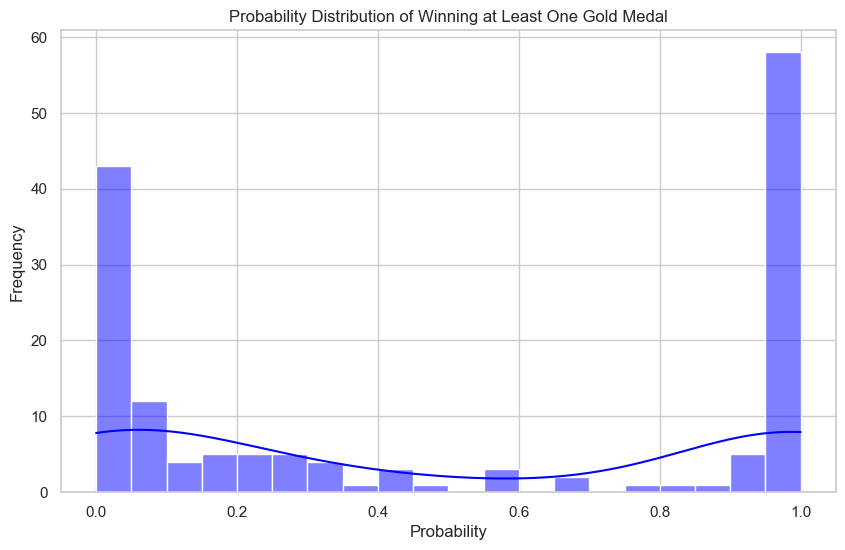

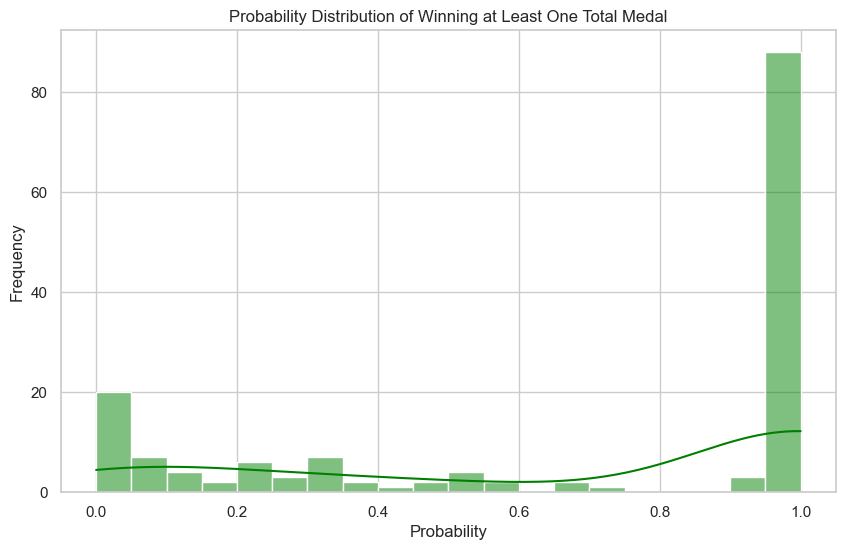

In [2]:
# 假设 df 是包含所有国家数据的 DataFrame
# 筛选出 Year == 2024 的数据
data_2024 = df[df['Year'] == 2024].copy()

# 将 Year 替换为 2028
data_2024['Year'] = 2028
data_2024.loc[data_2024['Country'] == 'United States', 'isHost'] = 1

# 确保特征列与训练时一致
X_2024 = data_2024[X_train.columns]

# 使用 Bootstrap 方法计算 Gold 模型的预测区间
n_bootstrap = 100  # Bootstrap 次数
predictions_gold_2028 = np.zeros((X_2024.shape[0], n_bootstrap))

for i in tqdm(range(n_bootstrap)):
    # 重采样训练数据
    sample_indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    X_sample = X_train.iloc[sample_indices]
    y_sample = y_train_gold.iloc[sample_indices]
    
    # 训练模型
    bst = xgb.XGBRegressor(**best_params)
    bst.fit(X_sample.values, y_sample.values)
    
    # 预测
    predictions_gold_2028[:, i] = bst.predict(X_2024.values)

# 计算均值和标准差
mean_predictions_gold_2028 = np.mean(predictions_gold_2028, axis=1)
std_predictions_gold_2028 = np.std(predictions_gold_2028, axis=1)

# 计算 95% 置信区间
lower_predictions_gold_2028 = mean_predictions_gold_2028 - 1.96 * std_predictions_gold_2028
upper_predictions_gold_2028 = mean_predictions_gold_2028 + 1.96 * std_predictions_gold_2028

# 将结果添加到数据中
data_2024['Predicted_Gold'] = mean_predictions_gold_2028
data_2024['Predicted_Gold_Lower'] = lower_predictions_gold_2028
data_2024['Predicted_Gold_Upper'] = upper_predictions_gold_2028

# 使用 Bootstrap 方法计算 Total 模型的预测区间
predictions_total_2028 = np.zeros((X_2024.shape[0], n_bootstrap))

for i in tqdm(range(n_bootstrap)):
    # 重采样训练数据
    sample_indices = np.random.choice(X_train.shape[0], X_train.shape[0], replace=True)
    X_sample = X_train.iloc[sample_indices]
    y_sample = y_train_total.iloc[sample_indices]
    
    # 训练模型
    bst = xgb.XGBRegressor(**best_params)
    bst.fit(X_sample.values, y_sample.values)
    
    # 预测
    predictions_total_2028[:, i] = bst.predict(X_2024.values)

# 计算均值和标准差
mean_predictions_total_2028 = np.mean(predictions_total_2028, axis=1)
std_predictions_total_2028 = np.std(predictions_total_2028, axis=1)

# 计算 95% 置信区间
lower_predictions_total_2028 = mean_predictions_total_2028 - 1.96 * std_predictions_total_2028
upper_predictions_total_2028 = mean_predictions_total_2028 + 1.96 * std_predictions_total_2028

# 将结果添加到数据中
data_2024['Predicted_Total'] = mean_predictions_total_2028
data_2024['Predicted_Total_Lower'] = lower_predictions_total_2028
data_2024['Predicted_Total_Upper'] = upper_predictions_total_2028

# ===================== 添加的内容：计算至少一枚奖牌的概率 =====================
# 计算每个国家获得至少一枚金牌的概率
prob_at_least_one_gold = np.mean(predictions_gold_2028 > 0.3, axis=1)
data_2024['Prob_At_Least_One_Gold'] = prob_at_least_one_gold

# 计算每个国家获得至少一枚总奖牌的概率
prob_at_least_one_total = np.mean(predictions_total_2028 > 0.3, axis=1)
data_2024['Prob_At_Least_One_Total'] = prob_at_least_one_total
# ===========================================================================

# 仅保留需要的列
result_2028 = data_2024[['Country', 
                         'Predicted_Gold', 'Predicted_Gold_Lower', 'Predicted_Gold_Upper', 'Prob_At_Least_One_Gold',
                         'Predicted_Total', 'Predicted_Total_Lower', 'Predicted_Total_Upper', 'Prob_At_Least_One_Total']]

# 保存预测结果到 CSV 文件
result_2028.to_csv('predictions_2028_with_intervals_and_probs.csv', index=False)

# 输出预测结果
print("2028 年奥运会得奖情况预测结果（包含预测区间和至少一枚奖牌的概率）：")
print(result_2028.head(10))

# ===================== 添加的内容：可视化概率分布 =====================
import matplotlib.pyplot as plt
import seaborn as sns

# 设置绘图风格
sns.set(style="whitegrid")

# 绘制至少获得一枚金牌的概率分布
plt.figure(figsize=(10, 6))
sns.histplot(data_2024['Prob_At_Least_One_Gold'], bins=20, kde=True, color='blue')
plt.title('Probability Distribution of Winning at Least One Gold Medal')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()

# 绘制至少获得一枚总奖牌的概率分布
plt.figure(figsize=(10, 6))
sns.histplot(data_2024['Prob_At_Least_One_Total'], bins=20, kde=True, color='green')
plt.title('Probability Distribution of Winning at Least One Total Medal')
plt.xlabel('Probability')
plt.ylabel('Frequency')
plt.show()
# ====================================================================

In [94]:
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import pandas as pd
import numpy as np
import xgboost as xgb
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

# 读取数据
file_path = "./data/merged_final_data.csv"
df = pd.read_csv(file_path)

# 序列化 NOC 列
le = LabelEncoder()
df['Country'] = df['NOC'].copy() 
df['NOC'] = le.fit_transform(df['NOC'].astype(str))
df['NOC'] = df['NOC'].astype(int)
joblib.dump(le, 'label_encoder.pkl')

# 标准化 Year 列
scaler = StandardScaler()
df['Year_Standardized'] = scaler.fit_transform(df[['Year']])

# 选择特征和目标变量
features = df.columns[4:].tolist()  # 从第五列到最后一列作为特征
features.append('NOC')  # 添加序列化后的 NOC 列
features.append('Year_Standardized')  # 添加标准化后的 Year 列
features = [col for col in features if col != 'Country']

target_gold = 'Gold'
target_total = 'Total'

# 分离特征和目标变量
X = df[features]
y_gold = df[target_gold]
y_total = df[target_total]

# 切分训练集和测试集
X_train, X_test, y_train_gold, y_test_gold = train_test_split(X, y_gold, test_size=0.2, random_state=7)
X_train_total, X_test_total, y_train_total, y_test_total = train_test_split(X, y_total, test_size=0.2, random_state=7)

# 确保 X_train 和 X_test 是 DataFrame 类型
X_train = pd.DataFrame(X_train, columns=features)
X_test = pd.DataFrame(X_test, columns=features)

# 最优参数
best_params = {
    'n_estimators': 850,
    'max_depth': 3,
    'learning_rate': 0.22504880706544744,
    'subsample': 0.5534027539665659,
    'colsample_bytree': 0.7885661336486579,
    'reg_lambda': 1.0442478073580164,  # L2 正则化项
    'gamma': 0.28845608683232876,      # 最小损失减少阈值
    'random_state': 42
}

# 使用最优参数训练 Gold 模型
bst_gold = xgb.XGBRegressor(**best_params)
bst_gold.fit(X_train.values, y_train_gold.values)  # 使用 .values 转换为 NumPy 数组
ypred_train_gold = bst_gold.predict(X_train.values)
ypred_test_gold = bst_gold.predict(X_test.values)

# 输出 Gold 模型的评价指标
print('Gold Prediction:')
mae_train_gold = metrics.mean_absolute_error(y_train_gold, ypred_train_gold)
mse_train_gold = metrics.mean_squared_error(y_train_gold, ypred_train_gold)
r2_train_gold = metrics.r2_score(y_train_gold, ypred_train_gold)

mae_test_gold = metrics.mean_absolute_error(y_test_gold, ypred_test_gold)
mse_test_gold = metrics.mean_squared_error(y_test_gold, ypred_test_gold)
r2_test_gold = metrics.r2_score(y_test_gold, ypred_test_gold)

rmse_train_gold = np.sqrt(mse_train_gold)
rmse_test_gold = np.sqrt(mse_test_gold)

print(f'Train - Mean Absolute Error: {mae_train_gold:.4f}')
print(f'Train - Mean Squared Error: {mse_train_gold:.4f}')
print(f"Train RMSE: {rmse_train_gold:.4f}")
print(f'Train - R^2 Score: {r2_train_gold:.4f}')

print(f'Test - Mean Absolute Error: {mae_test_gold:.4f}')
print(f'Test - Mean Squared Error: {mse_test_gold:.4f}')
print(f"Test RMSE: {rmse_test_gold:.4f}")
print(f'Test - R^2 Score: {r2_test_gold:.4f}')

# 保存 Gold 模型
joblib.dump(bst_gold, 'xgb_model_gold.pkl')

# 使用最优参数训练 Total 模型
bst_total = xgb.XGBRegressor(**best_params)
bst_total.fit(X_train.values, y_train_total.values)  # 使用 .values 转换为 NumPy 数组
ypred_train_total = bst_total.predict(X_train.values)
ypred_test_total = bst_total.predict(X_test.values)

# 输出 Total 模型的评价指标
print('Total Prediction:')
mae_train_total = metrics.mean_absolute_error(y_train_total, ypred_train_total)
mse_train_total = metrics.mean_squared_error(y_train_total, ypred_train_total)
r2_train_total = metrics.r2_score(y_train_total, ypred_train_total)

mae_test_total = metrics.mean_absolute_error(y_test_total, ypred_test_total)
mse_test_total = metrics.mean_squared_error(y_test_total, ypred_test_total)
r2_test_total = metrics.r2_score(y_test_total, ypred_test_total)

rmse_train_total = np.sqrt(mse_train_total)
rmse_test_total = np.sqrt(mse_test_total)

print(f'Train - Mean Absolute Error: {mae_train_total:.4f}')
print(f'Train - Mean Squared Error: {mse_train_total:.4f}')
print(f"Train RMSE: {rmse_train_total:.4f}")
print(f'Train - R^2 Score: {r2_train_total:.4f}')

print(f'Test - Mean Absolute Error: {mae_test_total:.4f}')
print(f'Test - Mean Squared Error: {mse_test_total:.4f}')
print(f"Test RMSE: {rmse_test_total:.4f}")
print(f'Test - R^2 Score: {r2_test_total:.4f}')

# 保存 Total 模型
joblib.dump(bst_total, 'xgb_model_total.pkl')

Gold Prediction:
Train - Mean Absolute Error: 0.2014
Train - Mean Squared Error: 0.0721
Train RMSE: 0.2686
Train - R^2 Score: 0.9986
Test - Mean Absolute Error: 1.4955
Test - Mean Squared Error: 10.6815
Test RMSE: 3.2683
Test - R^2 Score: 0.8342
Total Prediction:
Train - Mean Absolute Error: 0.2176
Train - Mean Squared Error: 0.0846
Train RMSE: 0.2909
Train - R^2 Score: 0.9998
Test - Mean Absolute Error: 2.1812
Test - Mean Squared Error: 25.5390
Test RMSE: 5.0536
Test - R^2 Score: 0.9321


['xgb_model_total.pkl']